[INFO] Using exported model: /Users/imalsky/Desktop/Goswami_keep_to_test/models/1/complete_model_exported_k1.pt2
[DEBUG] y0_noHe sum (should be 1): 1.000000e+00


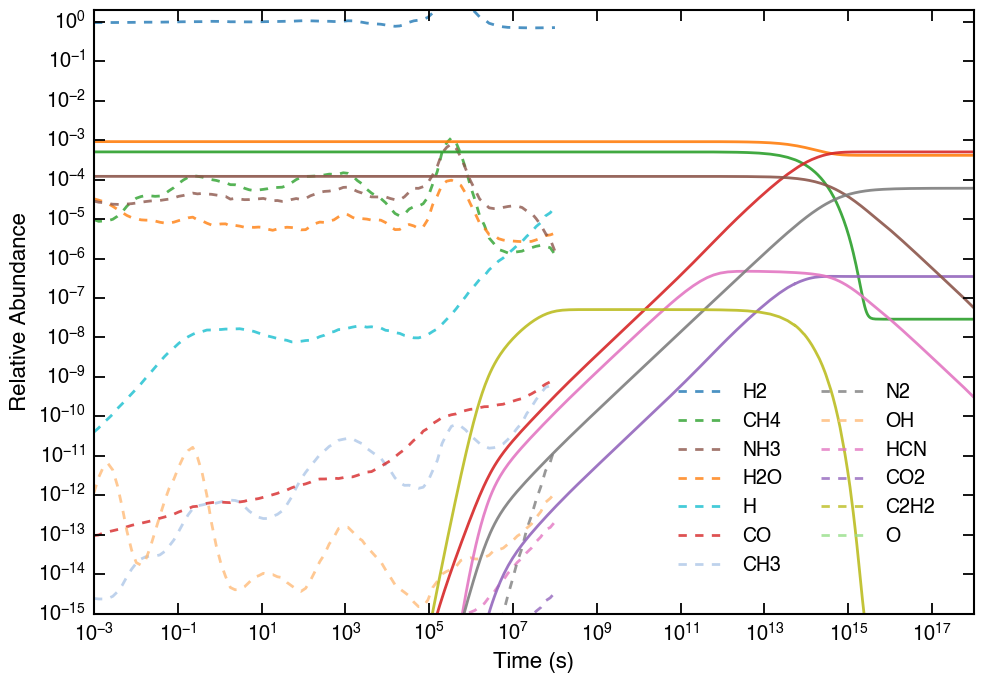

In [9]:
#!/usr/bin/env python3
"""
Panel-1 only, minimal build (robust to notebooks / REPL and string paths):
- EXACT initial conditions (1000 K, 1 mbar) with He provided.
- Map to the model's 13 target species (*_evolution).
- Floor tiny values to 1e-25, then renormalize ACROSS THE 13 TARGETS (no-He simplex) to sum=1.
- Feed this to the exported K=1 model (P in barye, T in K).
- Evaluate on t in [1e0, 1e8] (log-spaced).
- Plot dashed model trajectories; hollow circle at the first model time showing the (no-He) initial value.
"""

from __future__ import annotations
import os, sys, json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import colormaps as cm

plt.style.use('science.mplstyle')

# ---------------- repo paths (robust to __file__ missing + string/Path mix) ----------------
try:
    HERE = Path(__file__).resolve().parent
except NameError:
    HERE = Path.cwd()  # fallback for notebooks/REPL

DEFAULT_REPO_ROOT = HERE.parent

# Optional overrides via env; always coerce to Path
_env_model = os.environ.get("MODEL_DIR")
_env_proc  = os.environ.get("PROCESSED_DIR")
_env_src   = os.environ.get("SRC_DIR")
_env_repo  = os.environ.get("REPO_ROOT")  # optional, if you want to force a repo root

REPO_ROOT = Path(_env_repo) if _env_repo else DEFAULT_REPO_ROOT
MODEL_DIR = Path(_env_model) if _env_model else (REPO_ROOT / "models" / "1")
PROCESSED_DIR = Path(_env_proc) if _env_proc else (REPO_ROOT / "data" / "processed")
SRC_DIR = Path(_env_src) if _env_src else (REPO_ROOT / "src")

# ---------------- model I/O ----------------
torch.set_num_threads(1)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

# Make sure we can import your normalizer from src/
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))
from normalizer import NormalizationHelper  # type: ignore

# ---------------- fixed targets (13) ----------------
TARGET_SPECIES = [
    "C2H2_evolution","CH3_evolution","CH4_evolution","CO2_evolution","CO_evolution",
    "H2O_evolution","H2_evolution","HCN_evolution","H_evolution","N2_evolution",
    "NH3_evolution","OH_evolution","O_evolution",
]
BASE_NAMES = [s[:-10] for s in TARGET_SPECIES]  # strip "_evolution"

# ---------------- EXACT initial conditions you gave (with He) ----------------
CASE1_SPECIES = ['H2','H2O','H','CH4','CO','CO2','N2','NH3','He']
CASE1_VALUES  = [9.975331e-01, 1.074060e-03, 0.000000e+00, 5.902400e-04,
                 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.415900e-04, 1.679000e-01]

# Thermo
T_K  = 1000.0
P_Pa = 100.0              # 1 mbar
P_barye = P_Pa * 10.0     # model expects barye

# Time grid (panel 1)
T_MIN, T_MAX = 1e-3, 1e8
K = 99

# Floors
FLOOR = 1e-20          # for inputs (avoid zeros in no-He normalization)
PLOT_FLOOR = 1e-30     # for log-plot only

def load_norm_and_model():
    man_path = PROCESSED_DIR / "normalization.json"
    if not man_path.exists():
        raise FileNotFoundError(f"Missing {man_path}. Set PROCESSED_DIR or REPO_ROOT correctly.")
    with open(man_path, "r") as f:
        manifest = json.load(f)
    norm = NormalizationHelper(manifest)
    globals_v = list((manifest.get("meta") or {}).get("global_variables") or [])
    if not globals_v:
        raise RuntimeError("No 'global_variables' in normalization.json meta")

    from torch.export import load as torch_load
    tried = []
    for name in ("complete_model_exported_k1.pt2","complete_model_exported_k1_int8.pt2",
                 "complete_model_exported.pt2","complete_model_exported_int8.pt2"):
        p = MODEL_DIR / name
        tried.append(str(p))
        if p.exists():
            print(f"[INFO] Using exported model: {p}")
            mod = torch_load(str(p)).module()
            return norm, globals_v, mod
    raise FileNotFoundError("No exported model found. Tried:\n  " + "\n  ".join(tried))

def make_y0_noHe_from_case1() -> np.ndarray:
    """
    Use your with-He list; map to 13 targets by base name; floor to 1e-25; renorm across 13 to sum=1.
    The model runs on the 13-target simplex (no He).
    """
    base_to_val = {k: float(v) for k, v in zip(CASE1_SPECIES, CASE1_VALUES)}
    # map to the 13 target bases (missing -> FLOOR), then renormalize
    raw = np.array([max(base_to_val.get(b, FLOOR), FLOOR) for b in BASE_NAMES], dtype=np.float64)
    s_raw = float(raw.sum())
    if not np.isfinite(s_raw) or s_raw <= 0:
        raise RuntimeError("Bad raw sum for y0")
    y0_noHe = (raw / s_raw).astype(np.float32)
    print(f"[DEBUG] y0_noHe sum (should be 1): {float(y0_noHe.sum()):.6e}")
    return y0_noHe

@torch.inference_mode()
def predict_series_k1(fn, y0n: torch.Tensor, gn: torch.Tensor, t_hat: torch.Tensor) -> np.ndarray:
    out = []
    for k in range(int(t_hat.numel())):
        yk = fn(y0n, gn, t_hat[k:k+1])
        if not isinstance(yk, torch.Tensor):
            yk = torch.as_tensor(yk)
        out.append(yk.reshape(1, -1))
    return torch.cat(out, dim=0).cpu().numpy()

norm, globals_v, fn = load_norm_and_model()

# === build y0 (no-He) in TARGET_SPECIES order ===
y0_noHe = make_y0_noHe_from_case1()

# === globals vector (P in barye, T in K) ===
g = np.zeros((1, len(globals_v)), dtype=np.float32)
for i, name in enumerate(globals_v):
    n = name.strip().lower()
    if n.startswith("p"):
        g[0, i] = P_barye
    elif n.startswith("t"):
        g[0, i] = T_K
    else:
        g[0, i] = 0.0

# === times ===
eps = float(getattr(norm, "epsilon", 1e-30))
t_phys = np.logspace(np.log10(T_MIN), np.log10(T_MAX), K, dtype=np.float32)
t_hat  = norm.normalize_dt_from_phys(torch.from_numpy(np.clip(t_phys, eps, None)))

# === normalize inputs ===
y0n = norm.normalize(torch.from_numpy(y0_noHe.reshape(1, -1)), TARGET_SPECIES)
gn  = norm.normalize(torch.from_numpy(g), globals_v)

# === predict & denorm ===
ypred_n = predict_series_k1(fn, y0n, gn, t_hat)           # [K,S] normalized
ypred   = norm.denormalize(torch.from_numpy(ypred_n), TARGET_SPECIES).numpy()  # [K,S] physical (13-simplex)

# === Load VULCAN data ===
# EDIT THIS PATH:
VULCAN_PATH = Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul")

with open(VULCAN_PATH, "rb") as h:
    d = pickle.load(h)

vulcan_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'HCN', 'N2', 'C2H2']
t = np.asarray(d["variable"]["t_time"], dtype=float)               # [T]
Y = np.asarray(d["variable"]["y_time"], dtype=float)               # [T, layer, S]
den = np.maximum(Y[:,0,:].sum(axis=-1), 1e-30)                     # total incl. He
MR = Y[:,0,:] / den[:,None]                                        # mixing ratios (incl. He in denom)

# === Define color mapping ===
# Map species names to a consistent color scheme
color_map = {
    'H2': '#1f77b4',      # blue
    'H2O': '#ff7f0e',     # orange
    'CH4': '#2ca02c',     # green
    'CO': '#d62728',      # red
    'CO2': '#9467bd',     # purple
    'NH3': '#8c564b',     # brown
    'HCN': '#e377c2',     # pink
    'N2': '#7f7f7f',      # gray
    'C2H2': '#bcbd22',    # olive
    'H': '#17becf',       # cyan
    'CH3': '#aec7e8',     # light blue
    'OH': '#ffbb78',      # light orange
    'O': '#98df8a',       # light green
}

# === Create the plot ===
fig, ax = plt.subplots(figsize=(10, 7))

# Store legend entries with their max abundances for sorting
legend_entries = []

# Plot model predictions (dashed lines)
for i, sp in enumerate(TARGET_SPECIES):
    base_name = BASE_NAMES[i]
    color = color_map.get(base_name, '#333333')
    line, = ax.loglog(t_phys, np.maximum(ypred[:, i], PLOT_FLOOR), '--', 
                      lw=2, color=color, alpha=0.8)
    max_abundance = np.max(ypred[:, i])
    legend_entries.append((max_abundance, line, f"{base_name}"))

# Plot VULCAN data (solid lines)
# Map VULCAN species indices
vulcan_indices = {}
for j, sp in enumerate(vulcan_species):
    # Find the index in the VULCAN data
    for idx, name in enumerate(d["variable"]["species"]):
        if name == sp:
            vulcan_indices[sp] = idx
            break

for sp in vulcan_species:
    if sp in vulcan_indices:
        idx = vulcan_indices[sp]
        color = color_map.get(sp, '#333333')
        line, = ax.loglog(t, np.maximum(MR[:, idx], PLOT_FLOOR), '-', 
                         lw=2, color=color, alpha=0.9)
        max_abundance = np.max(MR[:, idx])

# Sort legend entries by abundance (highest first)
legend_entries.sort(key=lambda x: x[0], reverse=True)

# Create legend with sorted entries
lines = [entry[1] for entry in legend_entries]
labels = [entry[2] for entry in legend_entries]

# === Styling ===
ax.set_xlabel("Time (s)", fontsize=16, fontweight='medium')
ax.set_ylabel("Relative Abundance", fontsize=16, fontweight='medium')

# Set axis limits
ax.set_xlim(1e-3, 1e18)
ax.set_ylim(1e-15, 2)


# Legend styling - split into two columns for better readability
legend = ax.legend(lines, labels, 
                   fontsize=14, 
                   ncol=2, 
                   loc='lower right',
                   borderpad=1,
                   columnspacing=2,
                   handlelength=2.5)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()